In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class MelodyDataset(Dataset):
    def __init__(self, melodies, seq_length=32):
        self.seq_length = seq_length
        self.data = []
        self.labels = []
        
        # Process each melody
        for melody_idx, melody in enumerate(melodies):
            # Convert melody to tensor
            melody_tensor = torch.tensor(melody, dtype=torch.float32)
            
            # Create sequences
            for i in range(len(melody) - seq_length):
                seq = melody_tensor[i:i+seq_length]
                target = melody_tensor[i+1:i+seq_length+1]
                self.data.append(seq)
                self.labels.append(target)
        
        self.data = torch.stack(self.data)
        self.labels = torch.stack(self.labels)
        
        # Normalize data
        self.scaler = StandardScaler()
        original_shape = self.data.shape
        self.data = torch.tensor(
            self.scaler.fit_transform(self.data.reshape(-1, 4)).reshape(original_shape),
            dtype=torch.float32
        )
        self.labels = torch.tensor(
            self.scaler.transform(self.labels.reshape(-1, 4)).reshape(self.labels.shape),
            dtype=torch.float32
        )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [5]:
class MelodyTransformer(nn.Module):
    def __init__(self, input_dim=4, d_model=128, nhead=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_projection = nn.Linear(d_model, input_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask=None):
        # Project input
        src = self.input_projection(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src.transpose(0, 1)).transpose(0, 1)
        src = self.dropout(src)
        
        # Transform
        output = self.transformer(src, src_mask)
        output = self.output_projection(output)
        
        return output

In [6]:
def train_model(model, dataloader, epochs=50, lr=0.001):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    return losses

In [7]:
def generate_melody(model, seed_sequence, length=64, temperature=1.0):
    model.eval()
    with torch.no_grad():
        seed = torch.tensor(seed_sequence, dtype=torch.float32).unsqueeze(0).to(device)
        generated = seed.clone()
        
        for _ in range(length):
            # Use last 32 notes as context
            context = generated[:, -32:] if generated.size(1) > 32 else generated
            output = model(context)
            
            # Apply temperature and sample
            next_note = output[:, -1:] / temperature
            next_note = next_note + torch.randn_like(next_note) * 0.1
            
            generated = torch.cat([generated, next_note], dim=1)
        
        return generated.cpu().numpy()

Creating dataset...
Initializing model...
Model parameters: 3,559,300
Training model...
Epoch 0, Loss: 1.640987, LR: 0.001000
Epoch 10, Loss: 1.006579, LR: 0.001000
Epoch 20, Loss: 1.002583, LR: 0.000500
Epoch 30, Loss: 0.964140, LR: 0.000500
Epoch 40, Loss: 0.854875, LR: 0.000500
Epoch 50, Loss: 0.428735, LR: 0.000500
Epoch 60, Loss: 0.146470, LR: 0.000500
Epoch 70, Loss: 0.073152, LR: 0.000500
Epoch 80, Loss: 0.042483, LR: 0.000500
Epoch 90, Loss: 0.029454, LR: 0.000500


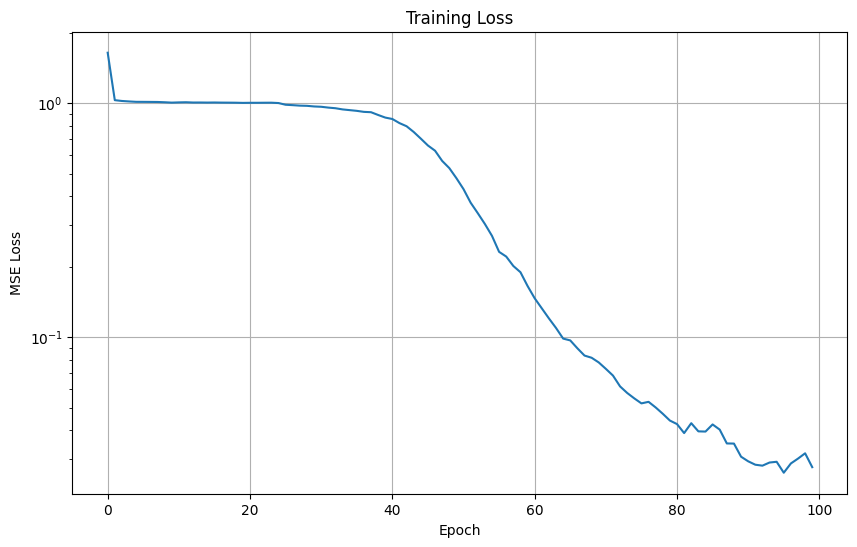

Generating melody...
Generated melody shape: (1, 96, 4)
Sample generated notes:
[[2.9000002e+01 7.6999998e+00 3.2000000e+00 1.2598424e-01]
 [5.2000000e+01 6.4000001e+00 3.7000000e+00 5.8267719e-01]
 [2.8000002e+01 8.1999998e+00 9.8999996e+00 5.4330707e-01]
 [4.4000000e+01 4.8000002e+00 7.0000023e-01 2.3622053e-02]
 [1.2300000e+02 5.1999998e+00 1.2700000e+01 2.7559054e-01]]


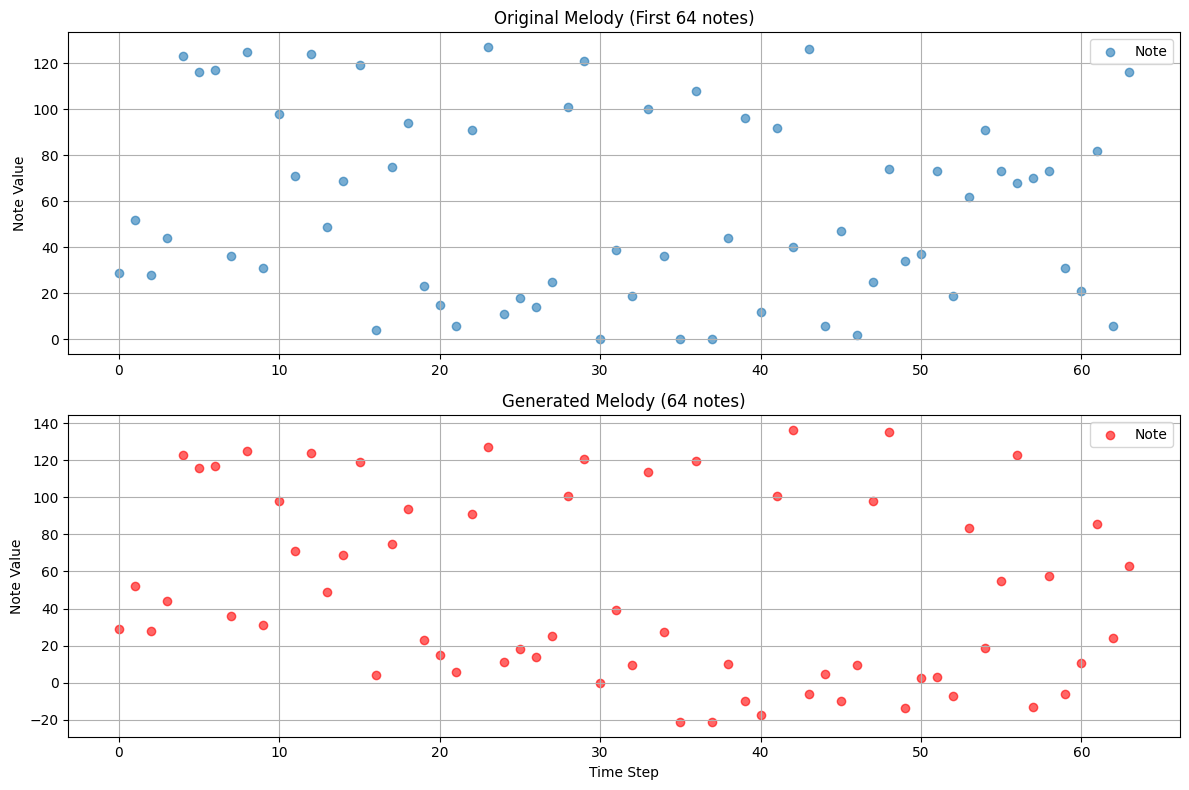

Pipeline complete!


In [8]:
# Example data - replace with your actual MIDI data
# Each melody is a list of [note, start, end, velocity]
melodies = [
    np.random.randint(0, 128, (100, 4)).astype(float),  # Melody 1
    np.random.randint(0, 128, (120, 4)).astype(float),  # Melody 2
    np.random.randint(0, 128, (80, 4)).astype(float),   # Melody 3
]

# Normalize timing values
for melody in melodies:
    melody[:, 1] = melody[:, 1] / 10.0  # start times
    melody[:, 2] = melody[:, 2] / 10.0  # end times
    melody[:, 3] = melody[:, 3] / 127.0 # velocity normalization

print("Creating dataset...")
dataset = MelodyDataset(melodies, seq_length=32)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

print("Initializing model...")
model = MelodyTransformer(input_dim=4, d_model=128, nhead=8, num_layers=6)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

print("Training model...")
losses = train_model(model, dataloader, epochs=100, lr=0.001)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.yscale('log')
plt.show()

# Generate new melody
print("Generating melody...")
seed = dataset.scaler.transform(melodies[0][:32].reshape(-1, 4)).reshape(32, 4)
generated = generate_melody(model, seed, length=64, temperature=0.8)

# Denormalize generated melody
generated_denorm = dataset.scaler.inverse_transform(
    generated.reshape(-1, 4)
).reshape(generated.shape)

print(f"Generated melody shape: {generated_denorm.shape}")
print("Sample generated notes:")
print(generated_denorm[0, :5])  # First 5 notes

# Plot generated vs original
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Original melody
original = melodies[0][:64]
ax1.scatter(range(len(original)), original[:, 0], alpha=0.6, label='Note')
ax1.set_title('Original Melody (First 64 notes)')
ax1.set_ylabel('Note Value')
ax1.legend()
ax1.grid(True)

# Generated melody
gen_plot = generated_denorm[0, :64]
ax2.scatter(range(len(gen_plot)), gen_plot[:, 0], alpha=0.6, label='Note', color='red')
ax2.set_title('Generated Melody (64 notes)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Note Value')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Pipeline complete!")